In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.linalg import kron
from scipy.sparse import spdiags

In [34]:
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny
nu = 0.001
beta = 1
D1 = 0.1
D2 = D1
x2 = np.linspace(-Lx/2, Lx/2, nx+1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny+1)
y = y2[:ny]
[X,Y]=np.meshgrid(x,y)

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

m=1 # number of spirals
u=np.tanh(np.sqrt(X**2+Y**2))*np.cos(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));
v=np.tanh(np.sqrt(X**2+Y**2))*np.sin(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));
T = 4
tspan = np.arange(0,T+0.5,0.5)

ut = fft2(u)
vt = fft2(v)
uvt0 = np.hstack([(ut.reshape(N)), (vt.reshape(N))])


In [35]:
np.shape(uvt0[0:N].reshape(N))

(4096,)

In [36]:
def spectral_rhs(t, uvt, nx, ny, N, D1, D2, beta):
    utc = uvt[:N]
    vtc = uvt[N:]
    ut = utc.reshape((nx,ny))
    vt = vtc.reshape((nx,ny))
    u = ifft2(ut)
    v = ifft2(vt)
    Asq = u**2 + v**2
    lam = 1- Asq
    ome = -beta*Asq
    rhs_u = (-D1*K*ut + fft2(lam*u - ome*v)).reshape(N)
    rhs_v = (-D2*K*vt + fft2(ome*u + lam*v)).reshape(N)
    rhs = np.hstack([(rhs_u), (rhs_v)])
    return rhs
uvtsol = solve_ivp(spectral_rhs, [tspan[0], tspan[-1]], uvt0, t_eval=tspan, args=(nx, ny, N, D1, D2, beta), method="RK45")
z = uvtsol.y
A1 = z
np.shape(A1)


(8192, 9)

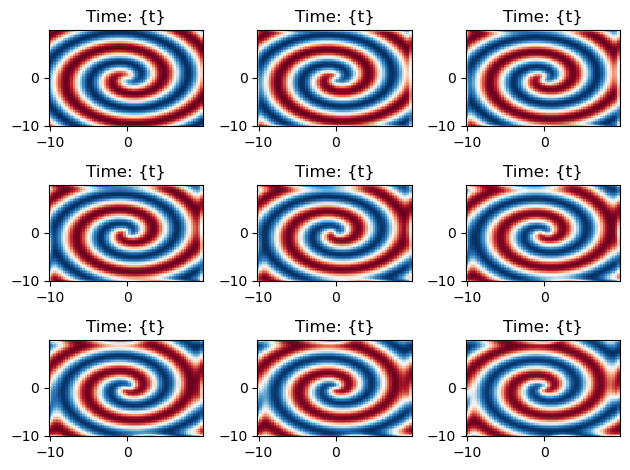

In [ ]:
#for j,t in enumerate(tspan):
#    u=np.real(ifft2(z[N:,j].reshape((nx,ny))))
#    plt.subplot(3,3,j+1)
#    plt.pcolor(x, y, u, cmap='RdBu_r')
#    plt.title('Time: {t}')
#    plt.colorbar
#plt.tight_layout()
#plt.show()

In [37]:
#Part A2

def cheb(N):
	if N==0: 
		D = 0.; x = 1.
	else:
		n = np.arange(0,N+1)
		x = np.cos(np.pi*n/N).reshape(N+1,1) 
		c = (np.hstack(( [2.], np.ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
		X = np.tile(x,(1,N+1))
		dX = X - X.T
		D = np.dot(c,1./c.T)/(dX+np.eye(N+1))
		D -= np.diag(np.sum(D.T,axis=0))
	return D, x.reshape(N+1)
N = 30
D, x = cheb(N)
D[N, :] = 0
D[0, :] = 0
Dxx = np.dot(D, D) / ((20/2)**2)
y=x
N2 = (N+1)*(N+1)
I = np.eye(len(Dxx))
L = kron(I,Dxx) + kron(Dxx, I)

X, Y = np.meshgrid(x, y)
X = X *(20/2)
Y = Y *(20/2)
m=1 # number of spirals
u=np.tanh(np.sqrt(X**2+Y**2))*np.cos(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));
v=np.tanh(np.sqrt(X**2+Y**2))*np.sin(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));

ut = fft2(u)
vt = fft2(v)

uv0 = np.hstack([u.reshape(N2),v.reshape(N2)])
np.shape(uv0)




(1922,)

In [38]:
def RD_2d(t, uv):
    u = uv[0:N2]
    v = uv[N2:]
    A2 = u**2 + v**2
    lam= 1- A2
    ome = -beta*A2
    rhsu = D1*np.dot(L,u) + lam*u - ome*v
    rhsv = D2*np.dot(L,v) + ome*u + lam*v
    rhs = np.hstack([rhsu,rhsv])
    return rhs
uvtsol = solve_ivp(RD_2d,[tspan[0],tspan[-1]],uv0,t_eval=tspan, arg=(), method='RK45')

In [39]:
A2 = uvtsol.y
np.shape(A2)

(1922, 9)